# Import packages

### Import python packages

In [1]:
import re,os
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
import imageio
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()

### Import custom packages

In [2]:
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from redatuming import redatuming
from latent import latent
from plot_training import plot_training
from plot_redatuming import plot_redatuming
from plot_save import plot_save
import symae_core as symae

Num GPUs Available:  1
TensorFlow Version:  2.9.1


# Generate dataset X

### Define $n_\varepsilon$ states

In [3]:
def g(n,x):
    if n==1:
        return int(x<0.5)
    elif n==2:
        return math.e**(-9*(x)**2)
    elif n==0:
        return math.cos(2*math.pi*x)

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 3 states')

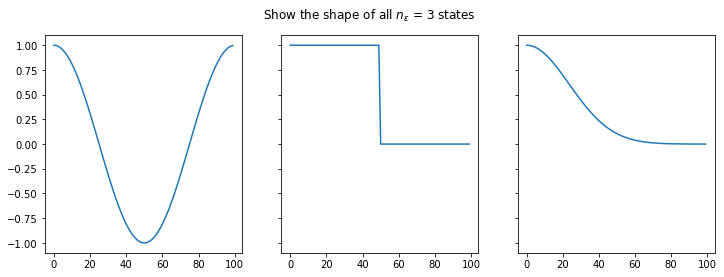

In [4]:
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

If replace==0, without replacement everywhere. Must $n_x*n_t <= n_\varepsilon*d$ and $n_t <= d$.  
If replace==1, X[i,:] have different nuisances, but each block in D can appear multiple times in X.  
If replace==2, with replacement everywhere.  
The default is replace=1.

In [5]:
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=0,continuous=True)

In [6]:
MRA_training.generate_default()
X = MRA_training.X

In [7]:
states = MRA_training.states
shifts = MRA_training.shifts

### Print the structure of dataset X

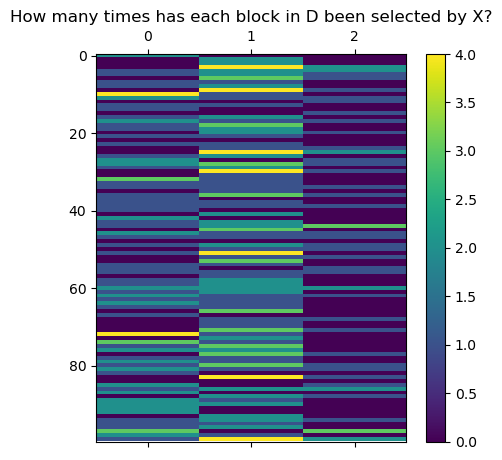

In [8]:
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

In [9]:
class LatentCat(tf.keras.Model):
    def __init__(self, alpha=1.0):
        super(LatentCat, self).__init__(name='')
        self.drop = tfkl.Dropout(alpha)
    def call(self, zsym, znuisance,training=False):
        znuisance = self.drop(znuisance, training=training)
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

In [10]:
class SymAE(tf.keras.Model):
    def __init__(self,N=1000,nt=20,d=100,p=8,q=22,kernel_size=5,
                 filters=64,dropout_rate=0.65): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder=symae.SymmetricEncoder1D(kernel_size,filters,
                                             [2,2,2,2],[2,2,2,2],p)
        sym_encoder._name='sym_encoder'
        self.sym_encoder=sym_encoder
        
        # Build nuisance encoder
        nui_encoder=symae.NuisanceEncoder1D(kernel_size,filters,
                                            [2,2,2],[2,2,2,2],q)
        nui_encoder._name='nui_encoder'
        self.nui_encoder=nui_encoder
        
        # Build distribute in decoder
        distzsym = symae.DistributeZsym(nt, p, q)
        distzsym._name = 'dist'
        self.distzsym = distzsym
        
        #Build mixer in decoder
        mixer = symae.Mixer1D(kernel_size,filters,10,d)
        mixer._name = 'mixer'
        self.mixer = mixer
        
        # Build latentcat
        latentcat = LatentCat(alpha=dropout_rate)
        latentcat._name = 'latentcat'
        self.latentcat = latentcat        
        
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,d,1), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output=latentcat(zsym,znuisance)
        encoder=tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder=encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output=mixer(distzsym(decoder_input))
        decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder=decoder
        
    def call(self, x):
        sym_code = self.sym_encoder(x)
        nui_code = self.nui_encoder(x)
        z = self.latentcat(sym_code, nui_code)
        dist = self.distzsym(z)
        out = self.mixer(dist)
        return out

### Initialize SymAE and load weights

In [11]:
model = SymAE(N,nt,d,p,q,kernel_size,filters,0.0)
model.load_weights('./checkpoint/'+'p=%d,q=%d,ne=%d'%(p,q,ne))
clear_output()

In [12]:
model.latentcat.drop.rate = 0.0

### Train the NeuralNet

In [13]:
optimizer = tf.keras.optimizers.Adam(0.001)
mse = tf.keras.losses.MeanSquaredError()

In [14]:
def reconstruction_loss(model, x, training=False):
    x_hat = model(x, training=True)
    return mse(x, x_hat)
def norm(x, ord=2, axis=-1):
    if ord==1:
        return tf.math.abs(x,axis=axis)
    elif ord==2:
        return tf.sqrt(tf.reduce_sum(tf.square(x), axis=axis) + 1.0e-12)
@tf.function
def set_distance(s1,s2):
    ''' |s1|=N*|s2| '''
    '''WARNING: this layer rely on broadcasting'''
    s1_ = tf.expand_dims(s1, 0)
    s1__ = tf.expand_dims(s1, 1)
    s2_ = tf.expand_dims(s2, 0)
    s2__ = tf.expand_dims(s2, 1)
    s12 = tf.reduce_mean(norm(s1_-s2__, axis=-1))
    s11 = tf.reduce_mean(norm(s1_-s1__, axis=-1))
    s22 = tf.reduce_mean(norm(s2_-s2__, axis=-1))
    s = s12-s11/2-s22/2
    return s
def mutual_info_penalty(model, x, training=False):
    z = model.encoder(x, training=False)
    coherent_code = z[:,0:p]
    nuisance_code = z[:,p:p+nt*q]
    all_points = tf.reshape(nuisance_code,[-1,q])
    std = tf.math.reduce_std(all_points, 0)
    std = tf.ones_like(std)
    s = 0.0
    for i in trange(z.shape[0]):
        s += set_distance(all_points, all_points[i*nt:(i+1)*nt,:])
    return s
@tf.function
def train_step(model, x, training=True):
    with tf.GradientTape() as tape:
        loss_rec = reconstruction_loss(model, x, training)
        loss_cor = mutual_info_penalty(model, x, training)
        loss = loss_rec + loss_cor*0
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_rec, loss_cor

In [ ]:
for epoch in range(10000):
    loss_rec, loss_cor = train_step(model, X)
    print("For epoch {:d}, reconstruction loss is {:f}, correlation loss is {:f}."
          .format(epoch, loss_rec, loss_cor))
    clear_output(wait=True)


KeyboardInterrupt



### Save weights

In [ ]:
model.save_weights('./checkpoint/p=%d,q=%d,ne=%d'%(p,q,ne))
print("weights saved")

weights saved


# Redatuming

In [ ]:
def find(state,nuisance):
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(1000):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j

### Choose which 2 states and shifts you want to redatum 

In [ ]:
MRA1, t1 = find(0,0)
MRA2, t2 = find(1,0)

### Redatuming and the visualize it

The MSE of C1N2 is: 1.025270
The MSE of C2N1 is: 0.629857


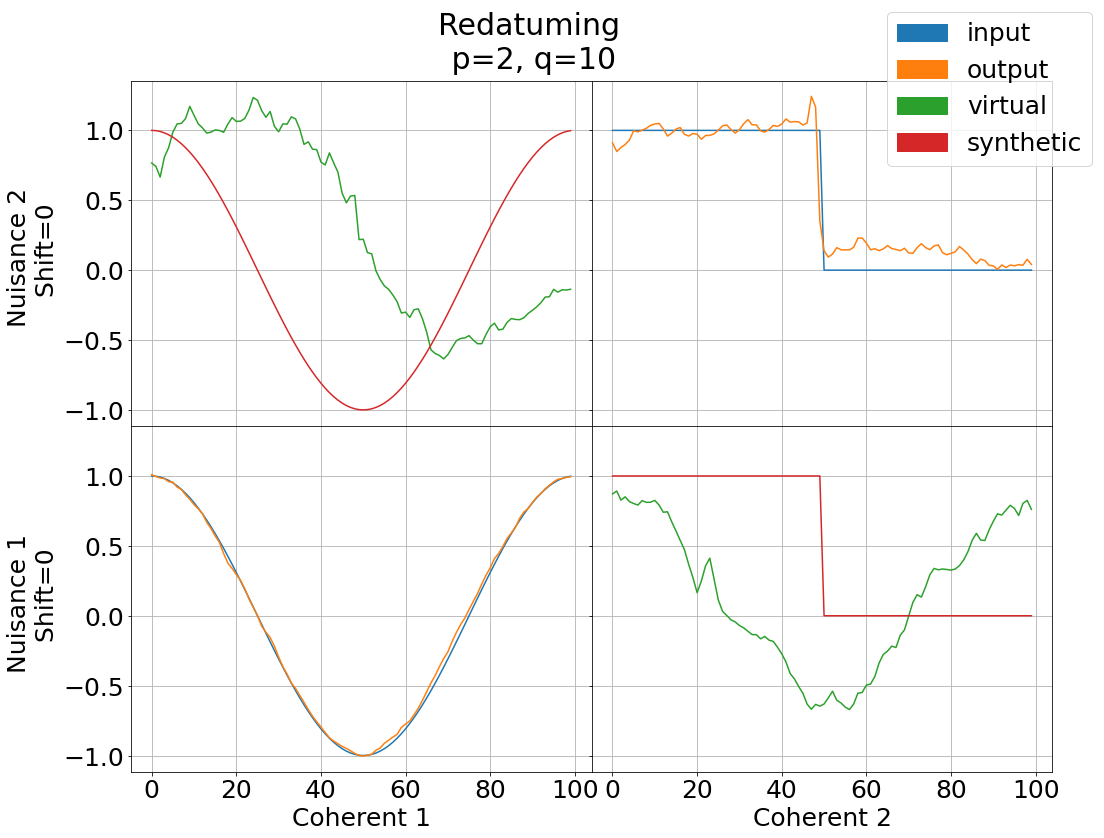

In [ ]:
redatum = redatuming(model,MRA1,MRA2,t1,t2)
#redatum = redatuming(model,MRA_training,MRA_training,0,0)
MSE_C1_N2, MSE_C2_N1 = redatum.MSE()
fig = plot_redatuming(redatum)
clear_output()
print('The MSE of C1N2 is: %f'%MSE_C1_N2)
print('The MSE of C2N1 is: %f'%MSE_C2_N1)

### Spline

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    MRA1, t1 = find(state,shift)
    tem = model.encoder(MRA1.X)
    return tf.concat([tem[0,0:p], tem[0,t1*q+p:(t1+q)*q+p]], axis=0)

In [ ]:
class spline():
    def __init__(self, state, Ns=0, shifts=0):
        if 1==0:
            self.state = state
            self.x = np.arange(0, d, 1)
            self.y = np.empty((q, len(self.x)))
            self.tck = []
            self.center = enc(state, 0)[0:p]
            for j in trange(len(self.x)):
                l = self.x[j]
                latent_code = enc(state, l)
                for i in range(q):
                    self.y[i,j] = latent_code[p+i]
        else:
            self.x = shifts
            self.y = Ns.T
            self.tck = []
            self.center = enc(state, 0)[0:p]

        for i in range(q):
            self.tck.append(interpolate.splrep(self.x, self.y[i,:], per=True))

    def call(self, shift):
        return np.array([interpolate.splev(shift, self.tck[i], der=0) for i in range(q)])
    def call_batch(self, shifts):
        return np.array([[interpolate.splev(shift, self.tck[i], der=0) for i in range(q)] for shift in shifts])
    def decode(self, shift):
        return dec(np.hstack([self.center, self.call(shift)]))
    def decode_batch(self, shifts):
        return np.array([self.decode(shift) for shift in tqdm(shifts)])

In [ ]:
Ns = model.nui_encoder(MRA_training.X)[MRA_training.states==0]
Ns = tf.reshape(Ns,[-1,q])
Ns = Ns.numpy()
shifts = MRA_training.shifts[MRA_training.states==0]
shifts = tf.reshape(shifts,[-1])
shifts = shifts.numpy()
subscripts = np.argsort(shifts)  
spline_obj = spline(0, Ns[subscripts], shifts[subscripts])

In [46]:
gif_images = []
for l in np.arange(0,100,0.1):
    clear_output(wait=True)
    y=spline_obj.decode(l)
    fig = plt.plot(range(d), y)
    plt.title('l=%f'%l)
    plt.savefig('test.png')
    gif_images.append(imageio.v2.imread('test.png'))
    plt.show()
imageio.mimsave("movie.gif",gif_images,fps=10)    

KeyboardInterrupt: 

In [47]:
imageio.mimsave("movie.gif",gif_images,fps=10)  

### PCA

In [28]:
pca = PCA(2)
Ns = model.nui_encoder(MRA_training.X)[MRA_training.states==0]
Ns = tf.reshape(Ns,[-1,q])
shifts = MRA_training.shifts[MRA_training.states==0].shape
shifts = tf.reshape(shifts,[-1,1])

In [29]:
pca_N = pca.fit_transform(Ns)
pca_N_spline = pca.transform(spline_obj.call_batch(np.arange(0,100,0.1)))

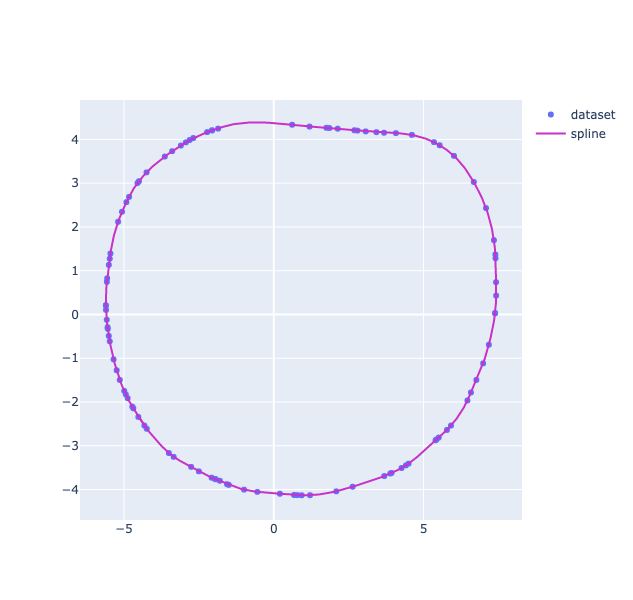

In [45]:
data0 = go.Scatter(x=pca_N[:,0], y=pca_N[:,1], mode='markers', name='dataset')
data_spline = go.Scatter(x=pca_N_spline[:,0], y=pca_N_spline[:,1], marker=dict(color='rgb(200, 50, 200)'), name='spline')
fig = go.Figure(data=[data0,data_spline])
fig.update_layout(height=600)
fig.show()